In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(1)

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids, headers = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

#### Studying the distribution of variables to detect possible categorical or faulty values

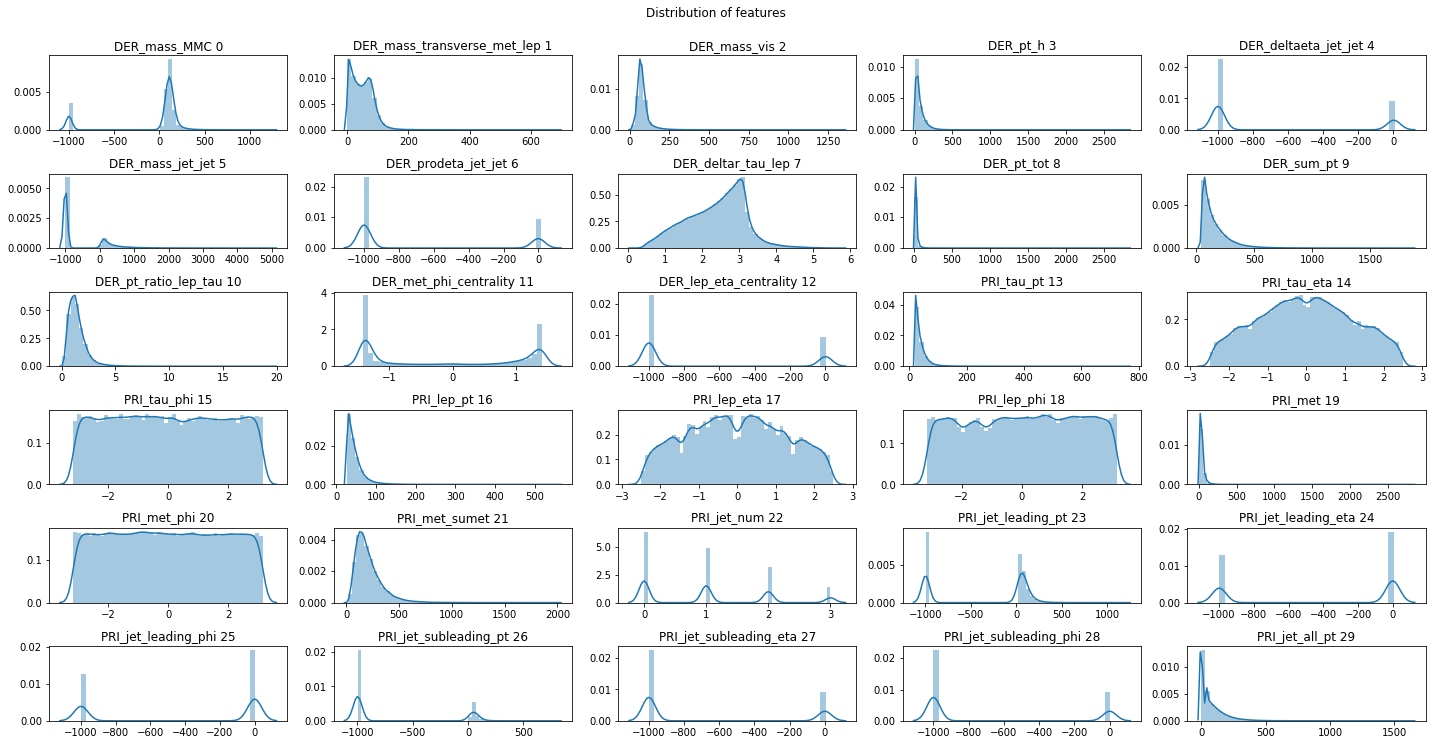

In [9]:
from plots import plot_feature_distribution
plot_feature_distribution(tX, headers, np.arange(len(headers)), "Distribution of features", 5, 6)

As we can see from these plots, different features have different distributions. We can also notice that there seems to be one categorical feature, namely `PRI_jet_num`. This feature is the number of jets used during the experiment. If we look at the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf), we can see that some feature are actually affected by the number of jets used.

Features affected by undefined values:
- `DER_mass_MMC` ID=0: undefined if topology of event too far from expected
- `DER_deltaeta_jet_jet` ID=4 : undefined if `PRI_jet_num` <= 1
- `DER_mass_jet_jet` ID=5: undefined if `PRI_jet_num` <= 1
- `DER_prodeta_jet_jet` ID=6: undefined if `PRI_jet_num` <= 1
- `DER_lep_eta_centrality` ID=12: undefined if `PRI_jet_num` <= 1
- `PRI_jet_leading_pt` ID=23: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_eta` ID=24: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_phi` ID=25: undefined if `PRI_jet_num` == 0
- `PRI_jet_subleading_pt` ID=26: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_eta` ID=27: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_phi` ID=28: undefined if `PRI_jet_num` <= 1

Hence, it might be a good idea to have estimators for each number of jets (0, 1, and more than 1).
Also, we can see that features `PRI_tau_phi`, `PRI_lep_phi` and `PRI_met_phi` have an almost uniform distribution, and from the plot below, they seem to have no effect on the label.
However, we will perform feature selection later on as to automatize the elimination of such features, that seem to have no effect.

For now, we will split the dataset into 3 categories:
- tX_0, y_0 : Features and labels for experiments with 0 jets
- tX_1, y_1 : Features and labels for experiments with 1 jet
- tX_2, y_2 : Features and labels for experiments with more than 1 jets


In [226]:
from utils import split_dataset, get_feature_columns

jet_column = 22
tX_0, y_0, tX_1, y_1, tX_2, y_2 = split_dataset(tX, y, jet_col=jet_column)

Now that we have split the dataset, we need to select the columns that are meaningful for each category. For that we have created a function `get_feature_columns` that returns the indices of those columns who have a non null variance.

In [227]:
features_0 = get_feature_columns(tX_0)
features_1 = get_feature_columns(tX_1)
features_2 = get_feature_columns(tX_2)

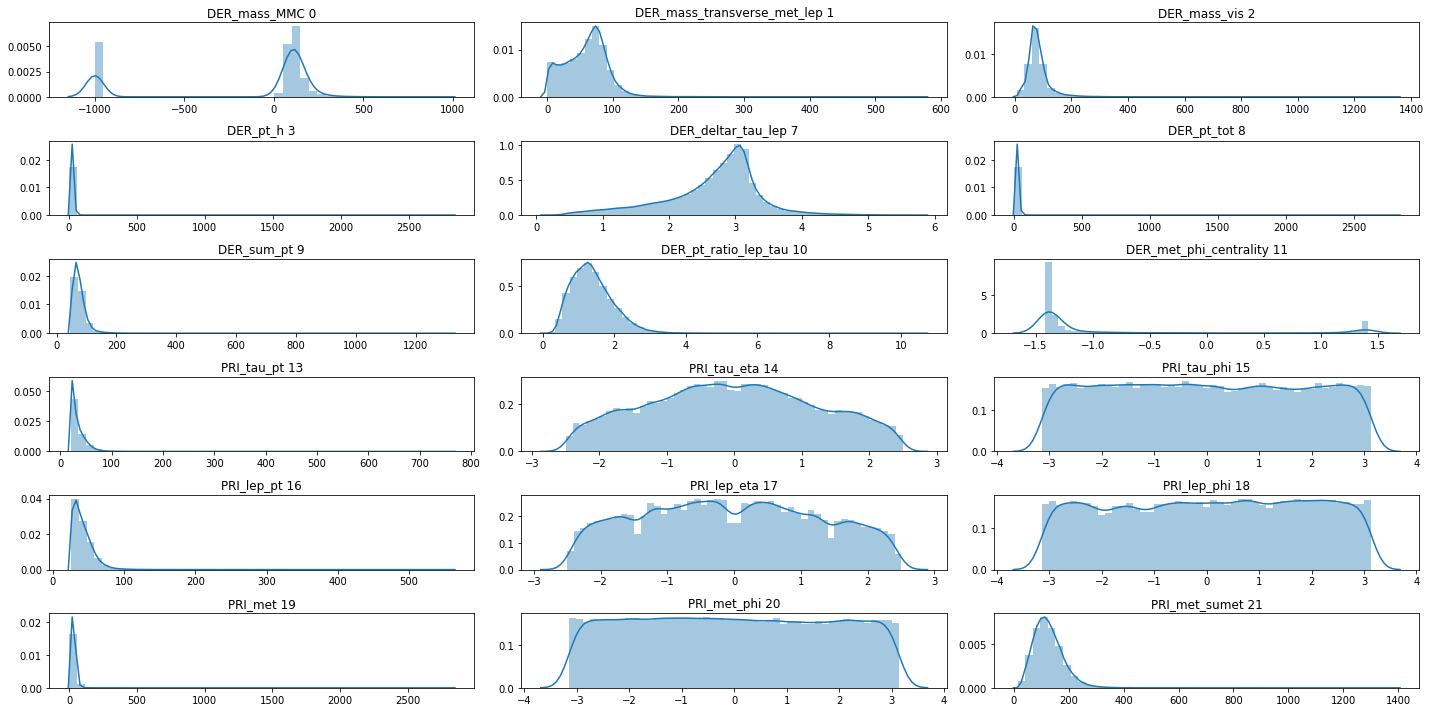

In [67]:
plot_feature_distribution(tX_0, headers, features_0, "", 3, 6)

In [228]:
from plots import plot_label_distribution

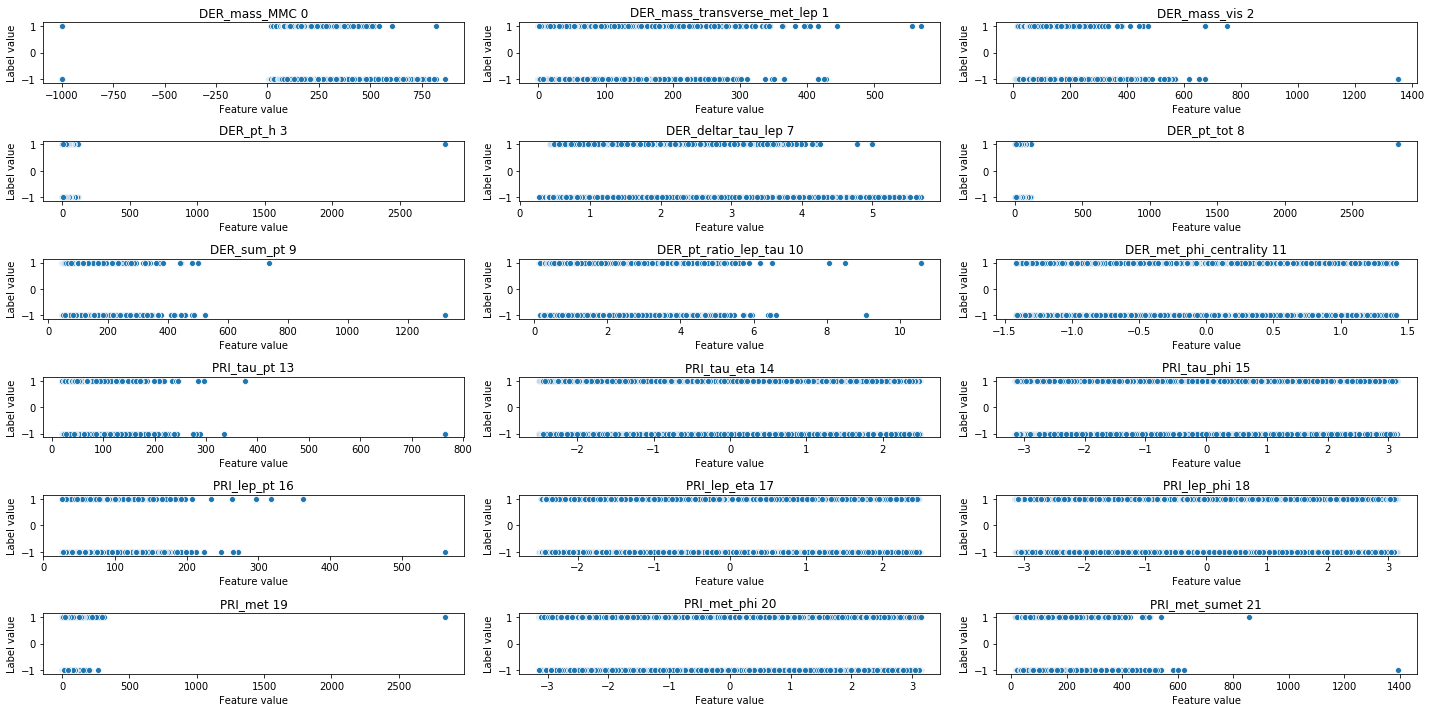

In [229]:
plot_label_distribution(tX_0, y_0, headers, features_0, "", 3, 6, )

In [124]:
tX_0 = tX_0[:, features_0]
tX_1 = tX_1[:, features_1]
tX_2 = tX_2[:, features_2]


# At this point, we should think of a automated function that selects the best model for each category:
1. Standardize the columns
2. Add a first column to tX_i for the bias
3. Perform feature selection/model selection

In [125]:
from utils import split_data, standardize_matrix_columns
from implementations import least_squares, least_squares_GD, least_squares_SGD, ridge_regression, logistic_regression, reg_logistic_regression

In [126]:
tX_0 = standardize_matrix_columns(tX_0)
tX_0 = np.c_[np.ones((y_0.shape[0], 1)), tX_0]
y_0 = np.vstack(y_0)

In [140]:
train_ratio = 0.75
x_train, y_train, x_test, y_test = split_data(tX_0, y_0, train_ratio)

In [128]:
from cross_validation import cross_validation_ls_gd

In [133]:
gammas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
best_weights, losses_te, acc_te, losses_tr, acc_tr = cross_validation_ls_gd(y_train, test, 4, gammas, 1000)

Gamma=1e-06, loss_te=22.339565342004942, acc_te=0.4461743772241993
Gamma=1e-06, loss_te=23.27959494034771, acc_te=0.45013345195729537
Gamma=1e-06, loss_te=21.802366104855178, acc_te=0.44337188612099643
Gamma=1e-06, loss_te=27.577939086274036, acc_te=0.45222419928825625
Gamma=1e-05, loss_te=21.242566665366738, acc_te=0.4465747330960854
Gamma=1e-05, loss_te=22.144920846520797, acc_te=0.450711743772242
Gamma=1e-05, loss_te=20.73313973696451, acc_te=0.44377224199288257
Gamma=1e-05, loss_te=26.339579000257956, acc_te=0.4530693950177936
Gamma=0.0001, loss_te=13.05313887161607, acc_te=0.4498220640569395
Gamma=0.0001, loss_te=13.640595717453765, acc_te=0.45355871886120996
Gamma=0.0001, loss_te=12.766293422023283, acc_te=0.4451067615658363
Gamma=0.0001, loss_te=16.861799468655764, acc_te=0.45556049822064054
Gamma=0.001, loss_te=0.8643394007302372, acc_te=0.580026690391459
Gamma=0.001, loss_te=0.8649250397439304, acc_te=0.5809163701067616
Gamma=0.001, loss_te=0.8788374731044581, acc_te=0.5744661

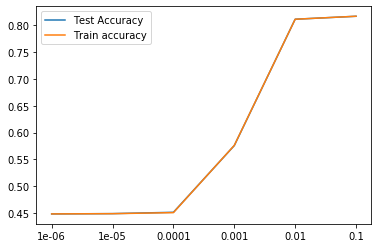

In [136]:
fig, ax = plt.subplots()
ax.plot(np.mean(acc_te, axis=1)) 
ax.plot(np.mean(acc_tr, axis=1))
plt.xticks(np.arange(len(gammas)), gammas);
plt.legend(["Test Accuracy", "Train accuracy"]);

### Least Square 

In [74]:
weights_ls = best_weights
score_ls = compute_accuracy(y_test, x_test, weights_ls)
print(f"Least squares got score of {score_ls}")

Least squares got score of 0.817654123298639


### Least Square GD using MSE

In [142]:
max_iters = 1000
rate = 1e-2
initial_w = np.zeros((x_train.shape[1], 1))
weights_ls_gd, loss_ls_gd = least_squares_GD(y_train, x_train, initial_w, max_iters, rate)
score_ls_gd = compute_accuracy(y_test, x_test, weights_ls_gd)
print(f"Least squares GD got score of {score_ls_gd}, loss of {loss_ls_gd}")

Gradient Descent(0/999): loss=0.5
Gradient Descent(100/999): loss=0.30750223035784974
Gradient Descent(200/999): loss=0.28832568513363765
Gradient Descent(300/999): loss=0.28323571173041584
Gradient Descent(400/999): loss=0.2806262178493771
Gradient Descent(500/999): loss=0.2787944112466424
Gradient Descent(600/999): loss=0.27739555942059196
Gradient Descent(700/999): loss=0.2763043247057584
Gradient Descent(800/999): loss=0.2754463788735
Gradient Descent(900/999): loss=0.2747685008053938
Least squares GD got score of 0.8150446374954963, loss of 0.2742305352619737


### Least Square SGD using MSE

In [152]:
max_iters = 10000
rate = 1e-3
initial_w = np.zeros((x_train.shape[1], 1))
weights_ls_sgd, loss_ls_sgd = least_squares_SGD(y_train, x_train, initial_w, max_iters, rate)

score_ls_sgd = compute_accuracy(y_test, x_test, weights_ls_sgd)
print(f"Least squares SGD got score of {score_ls_sgd}, loss of {loss_ls_sgd}")

Gradient Descent(0/9999): loss=0.5
Gradient Descent(1000/9999): loss=0.14597027762574982
Gradient Descent(2000/9999): loss=0.4482521203039793
Gradient Descent(3000/9999): loss=0.21338127155077208
Gradient Descent(4000/9999): loss=0.6916333772064189
Gradient Descent(5000/9999): loss=0.4500845577107704
Gradient Descent(6000/9999): loss=0.8517874138430579
Gradient Descent(7000/9999): loss=0.40218107497981365
Gradient Descent(8000/9999): loss=0.8280241835327067
Gradient Descent(9000/9999): loss=0.03454645345416474
Least squares SGD got score of 0.8178870251010849, loss of 0.2760362317227743


### Ridge Regression

In [156]:
lambda_ = 1e-4
weights_ridge, loss_ridge = ridge_regression(y_train, x_train, lambda_)

score_ridge = compute_accuracy(y_test, x_test, weights_ridge)
print(f"Ridge regression got score of {score_ridge}, loss of {loss_ridge}")

Ridge regression got score of 0.8172064534208735, loss of 0.2717544172094956


In [225]:
weights_ridge

array([[-0.4897949 ],
       [-0.02390252],
       [-0.2833306 ],
       [-0.41827747],
       [-0.02145241],
       [ 0.37028807],
       [-0.02144003],
       [ 0.15374651],
       [-0.17237066],
       [ 0.03007799],
       [ 0.10010912],
       [-0.0027052 ],
       [-0.0006097 ],
       [ 0.14402432],
       [ 0.00875302],
       [-0.00055925],
       [ 0.10432943],
       [-0.00473867],
       [ 0.03417015]])

### Logistic Regression

In [159]:
from utils import add_degrees

In [206]:
x_tr = add_degrees(x_train, 3, 2)
x_te = add_degrees(x_test, 3, 2)

In [192]:
y_train_log = y_train.copy()
y_train_log[np.where(y_train_log == -1)] = 0

In [207]:
max_iters = 1000
rate = 1e-5
initial_w = np.ones((x_tr.shape[1], 1))
weights_log, loss_log = logistic_regression(y_train_log, x_tr, initial_w, max_iters, rate)

score_log = compute_accuracy(y_test, x_te, weights_log)
print(f"Logistic regression got score of {score_log}, loss of {loss_log}")

Gradient Descent(0/999): loss=248281.76144006927
Gradient Descent(100/999): loss=30214.329663637676
Gradient Descent(200/999): loss=29721.461273480087
Gradient Descent(300/999): loss=29458.609466137274
Gradient Descent(400/999): loss=29311.69956756374
Gradient Descent(500/999): loss=29228.34969625239
Gradient Descent(600/999): loss=29180.452958681777
Gradient Descent(700/999): loss=29152.62056438643
Gradient Descent(800/999): loss=29136.29875858218
Gradient Descent(900/999): loss=29126.657940950867
Logistic regression got score of 0.8349813843628648, loss of 29120.931533943305


### Regularized Logistic Regression

In [217]:
max_iters = 1000
rate = 1e-5
lambda_ = 0.1
initial_w = np.ones((x_tr.shape[1], 1))
weights_log_r, loss_log_r = reg_logistic_regression(y_train_log, x_tr,lambda_, initial_w, max_iters, rate)

score_log_r = compute_accuracy(y_test, x_te, weights_log_r)
print(f"Regularized Logistic regression got score of {score_log_r}, loss of {loss_log_r}")

Gradient Descent(0/999): loss=248282.76144006927
Gradient Descent(100/999): loss=30214.528999911465
Gradient Descent(200/999): loss=29721.784173563316
Gradient Descent(300/999): loss=29459.053075647298
Gradient Descent(400/999): loss=29312.242188402364
Gradient Descent(500/999): loss=29228.966983078262
Gradient Descent(600/999): loss=29181.12419991311
Gradient Descent(700/999): loss=29153.3298247429
Gradient Descent(800/999): loss=29137.03435044497
Gradient Descent(900/999): loss=29127.411532765233
Regularized Logistic regression got score of 0.8350214179911125, loss of 29121.697302121564


## Generate predictions and save ouput in csv format for submission:

In [230]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test, _ = load_csv_data(DATA_TEST_PATH)

In [237]:
OUTPUT_PATH = 'test.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(np.ones((tX_test.shape[1], 1)), tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

array([-1., -1., -1., ...,  1.,  1., -1.])